# (LTT) Configure Source Model using class: Reflection_Source

XSPEC provides the `xspec.models.Reflection_Source` and `xspec.models.Transmission_Source` classes in order to provide an interpolation function over multiple source spectra simulations. 

The reflection source spectrum as a function of source voltage and anode angles can be written as:

$$
S^{sr}(E, v, \psi) = S^{sr}(E, v, \psi_0) \frac{Ph(E, v, \psi)}{Ph\left(E, v, \psi_0\right)}.
$$

where:

- $S^{sr}(E, v, \psi_0)$ is the interpolation function over a given list of spectra with different source voltages. It represents the source spectrum as a function of energy ($E$), source voltage ($v$), and a fixed anode angle ($\psi_0$), which serves as a reference.

- $Ph(E, v, \psi)$ is the Philibert absorption correction factor, applied in an analytical model that considers the anode angle. This factor corrects for the absorption effects that are dependent on the anode angle ($\psi$).

Here is an example to configure the provided reflection source class. With the source spectra provided, configure the X-ray source by defining two continuous variables, voltages, and takeoff angle. The process involves two principal steps:

1. Configure the source model with `Reflection_Source` by passing two continuous parameters, voltages, and takeoff angle, which should be a tuple (init value, min, max). Note that setting min and max to `None` indicates that we do not need to optimize this parameter.

2. Reflection sources are an interpolation-based model. Use `set_src_spec_list` to set up a list of simulation source spectra with corresponding source voltages.

In [ ]:
import numpy as np
import pyltt

def LTT_sim_source_sp(LTT, kV, takeOffAngle=11, anodeMaterial='W', energyBinSize=1, energyBinOffset=1):

    pyltt.reset(LTT, units='mm') #Use mm units for length
    
    LTT.run("takeOffAngle=%f"%takeOffAngle)
    LTT.run("simKV=%f"%kV)
    LTT.run("anodeMaterial=%s"%anodeMaterial)
    LTT.run("energyBinSize=%f"%energyBinSize)
    LTT.run("energyBinOffset=%f"%energyBinOffset)
    s_100 = LTT.getSpectrum()
    return  s_100

ltt_path = '/usr/workspace/prduePCI/LTT/IBM/python'
LTT = pyltt.ltt(ltt_path)


# Generate source spectra using Spekpy for a range of source voltages and a fixed takeoff angle.
min_simkV = 30
max_simkV = 200

simkV_list = np.linspace(min_simkV, max_simkV, 18, endpoint=True).astype('int')
reference_anode_angle = 11  # degrees
energies = np.linspace(1, max_simkV, max_simkV)  # energy range

src_spec_list = []
for simkV in simkV_list:
    # Creating a source spectrum array for each voltage
    src_spec = np.zeros((max_simkV))
    e,src_spec[:simkV] = LTT_sim_source_sp(LTT, simkV, reference_anode_angle)
    src_spec_list.append(src_spec)

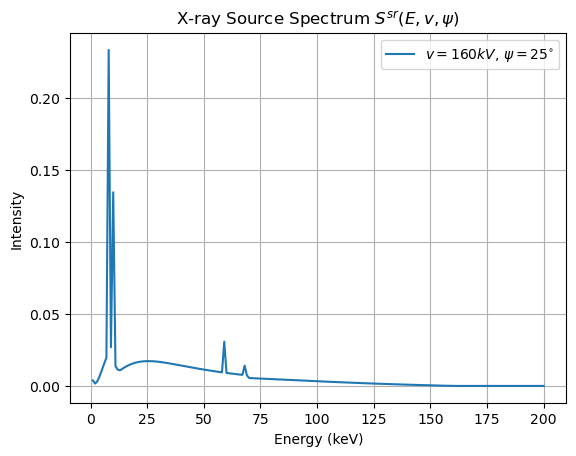

In [2]:
from xspec.models import Reflection_Source
import matplotlib.pyplot as plt
import torch

# Initialize the Reflection_Source model with specified voltage and takeoff angle ranges.
source = Reflection_Source(voltage=(160, 30, 200), takeoff_angle=(25, 5, 45), single_takeoff_angle=True)
source.set_src_spec_list(src_spec_list, simkV_list, reference_anode_angle)  # Set the source spectral list

# Plot the resulting spectrum without gradient descent modifications (torch.no_grad() context)
with torch.no_grad():
    plt.plot(energies, source(energies), label='$v=160 kV$, $\psi=25^{\circ}$')

plt.xlabel('Energy (keV)')  # X-axis label
plt.ylabel('Intensity')  # Y-axis label
plt.title('X-ray Source Spectrum $S^{sr}(E, v, \psi)$')  # Plot title
plt.legend()  # Add legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

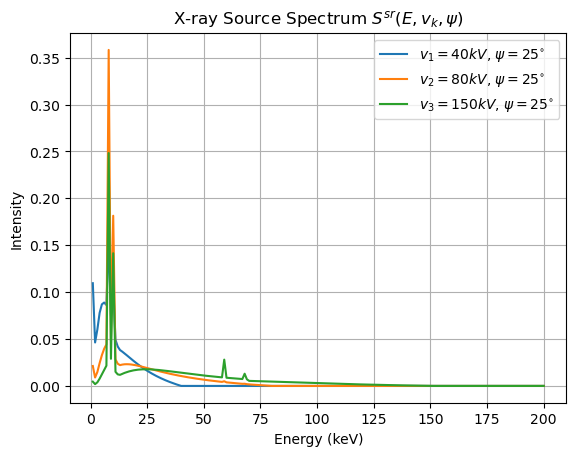

In [3]:
# Initialize the Reflection_Source model with specified voltage and takeoff angle ranges.
voltage_list = [40, 80, 150]
sources = [Reflection_Source(voltage=(v, 30, 200), takeoff_angle=(25, 5, 45), single_takeoff_angle=True) for v in voltage_list]
for si, source in enumerate(sources):
	source.set_src_spec_list(src_spec_list, simkV_list, reference_anode_angle)  # Set the source spectral list
	with torch.no_grad():
		plt.plot(energies, source(energies), label='$v_%d=%d kV$, $\psi=25^{\circ}$'%(si+1, voltage_list[si]))

plt.xlabel('Energy (keV)')  # X-axis label
plt.ylabel('Intensity')  # Y-axis label
plt.title('X-ray Source Spectrum $S^{sr}(E, v_k, \psi)$')  # Plot title
plt.legend()  # Add legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot